## A pipeline for processing and analyzing multiplexed images

#### Related project: A spatial single-cell type map of adult human spermatogenesis (Cecilia Bergström group)

### Import required libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io

# stardist
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import io, filters, measure, segmentation, color, util
from skimage.filters import threshold_otsu

import warnings
warnings.filterwarnings('ignore')


### Define input path, image of interest and other parameters

In [21]:
# define input path
inputpath = '/Users/giselemiranda/ToOneDrive/BIIF/projects/Feria_Cecilia/input/20456931/' # example '/Users/projects/'
ref_image = '20456931_Core[1,2,A]_[13058,43408]_component_data.tif'
ilastik_mask = '20456931_Core1,2,A_13058,43408_component_data_520_Simple Segmentation.tiff'

runBioEngine = False

# create output path
outpath = os.path.join(inputpath, 'output')
if not os.path.exists(outpath):
    os.makedirs(outpath)



### Load image of interest and define nuclei channel

In [22]:
# read reference image
ref_img = io.imread(os.path.join(inputpath, ref_image))

# select DAPI channel
nuclei = ref_img[0,:,:]
print("nuclei: loaded ", nuclei.shape)

nuclei: loaded  (3996, 3996)


### Run StarDist on the DAPI channel and save both label and binary masks

In [23]:
## Following example notebook from https://github.com/stardist/stardist

# prints a list of available models
#StarDist2D.from_pretrained()

if runBioEngine: ## Alternatively, run StarDist on the BioEngine (https://bioimage.io/#/)
    try:
        # For pyodide in the browser
        import micropip
        await micropip.install(['pyotritonclient', 'kaibu-utils'])
    except ImportError:
        # For native python with pip
        import subprocess
        subprocess.call(['pip', 'install', 'pyotritonclient', 'kaibu-utils'])

    from PIL import Image
    from pyotritonclient import execute
    from kaibu_utils import fetch_image
    
    # obtain the model config
    image = nuclei.astype('uint16')
    param = {'diameter': 30}

    # run inference
    results = await execute([image, param],
                                  server_url='https://ai.imjoy.io/triton',
                                  model_name='stardist',
                                  decode_bytes=True)
    labels = results['mask']
    
else: ## Run StarDist locally
    model = StarDist2D.from_pretrained('2D_versatile_fluo') # load pretrained model
    labels, _ = model.predict_instances(normalize(nuclei)) # get predictions for nuclei 

# get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(outpath + '/DAPI_labels.tif',labels)
io.imsave(outpath + '/DAPI_binary.tif',util.img_as_ubyte(binary_mask*255))


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 8s 8s/step


### Display segmentation output for the DAPI image

Text(0.5, 1.0, 'prediction + input overlay')

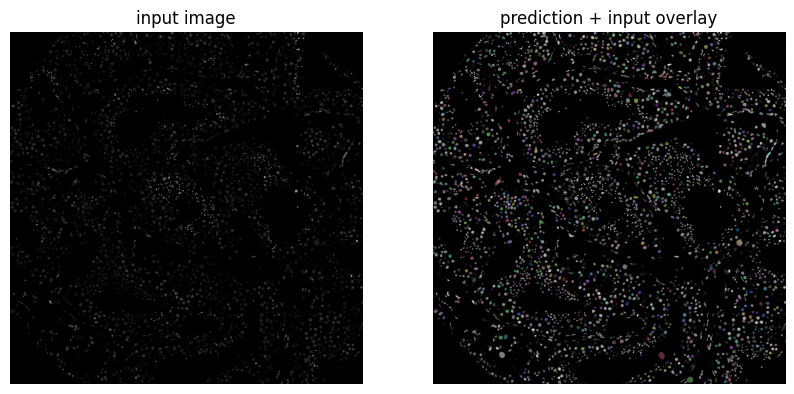

In [24]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(nuclei, cmap="gray", vmin=0, vmax=np.amax(nuclei))
ax1.axis("off")
ax1.set_title('input image')

ax2.imshow(render_label(labels, img=nuclei))
ax2.axis("off")
ax2.set_title('prediction + input overlay')


### Expand labels to incorporate cells' neighborhoods

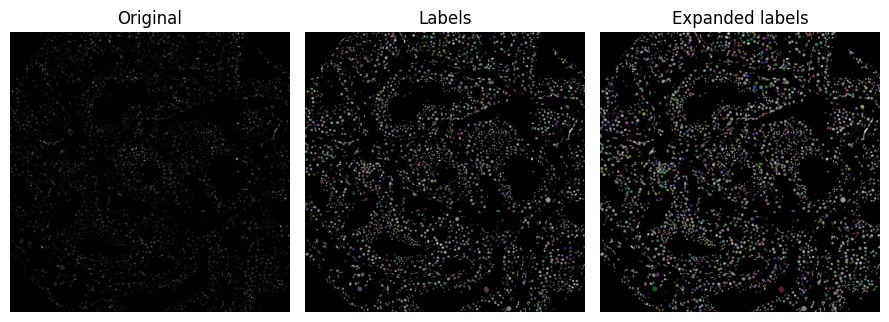

In [25]:
enlarged_labels = segmentation.expand_labels(labels, distance=3)

io.imsave(outpath + '/DAPI_labels_enlarged.tif',enlarged_labels)

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(nuclei, cmap="gray", vmin=0, vmax=np.amax(nuclei))
axes[0].set_title("Original")

axes[1].imshow(render_label(labels, img=nuclei))
axes[1].set_title("Labels")

axes[2].imshow(render_label(enlarged_labels, img=nuclei))
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()


### Retrieve quantitative measures
#### Get mean fluorescence intensity for each nuclei and for each channel and save results on a dataframe


In [26]:
def nonzero_intensity_mean(mask: np.ndarray, img: np.ndarray) -> float:
    data = img[mask]
    data = data[data != 0]
    
    if data.size != 0:
        return np.mean(data)
    else:
        return 0
    
    
def export_table_to_dataframe(tables, cols):
    tables = [pd.DataFrame(table) for table in tables] # create dataframe for each table
    tables = [table.set_index('label') for table in tables] # reset segmentation label as table index
    
    mean_intens = pd.concat(tables, axis=1)
    mean_intens.columns = cols
    return mean_intens


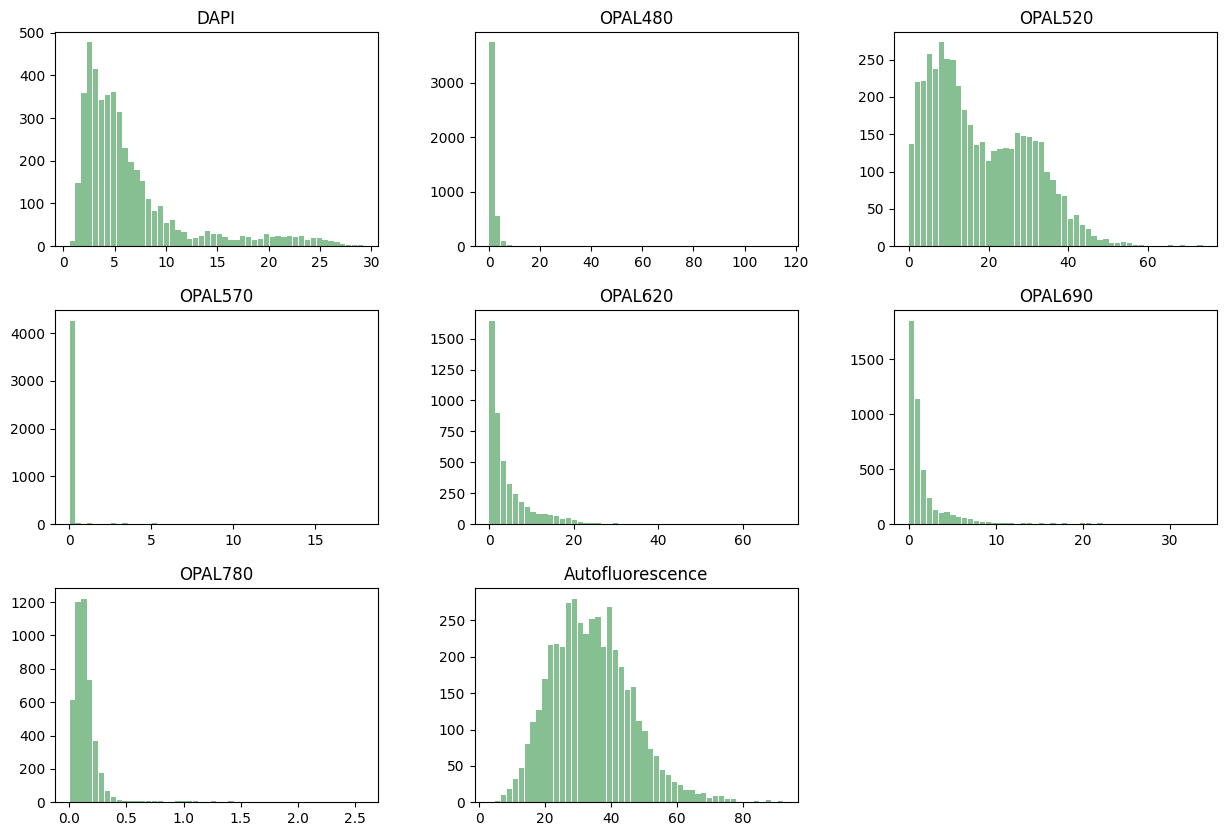

In [27]:
images = [ref_img[(x),:,:] for x in range(ref_img.shape[0])]

properties = ['label', 'intensity_mean']
cols = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']

tables = [measure.regionprops_table(labels, image, properties=properties)
          for image in images]
mean_intens = export_table_to_dataframe(tables, cols)
mean_intens.to_csv(os.path.join(outpath, 'mean_intensity.csv'), sep=';')
mean_intens

nBins = 50
ax = mean_intens.hist(bins=nBins, grid=False, figsize=(15,10), color='#86bf91', zorder=2, rwidth=0.9)

#### Get mean fluorescence intensity for each nuclei and for each channel, given the thresholded masks, and save results on a dataframe

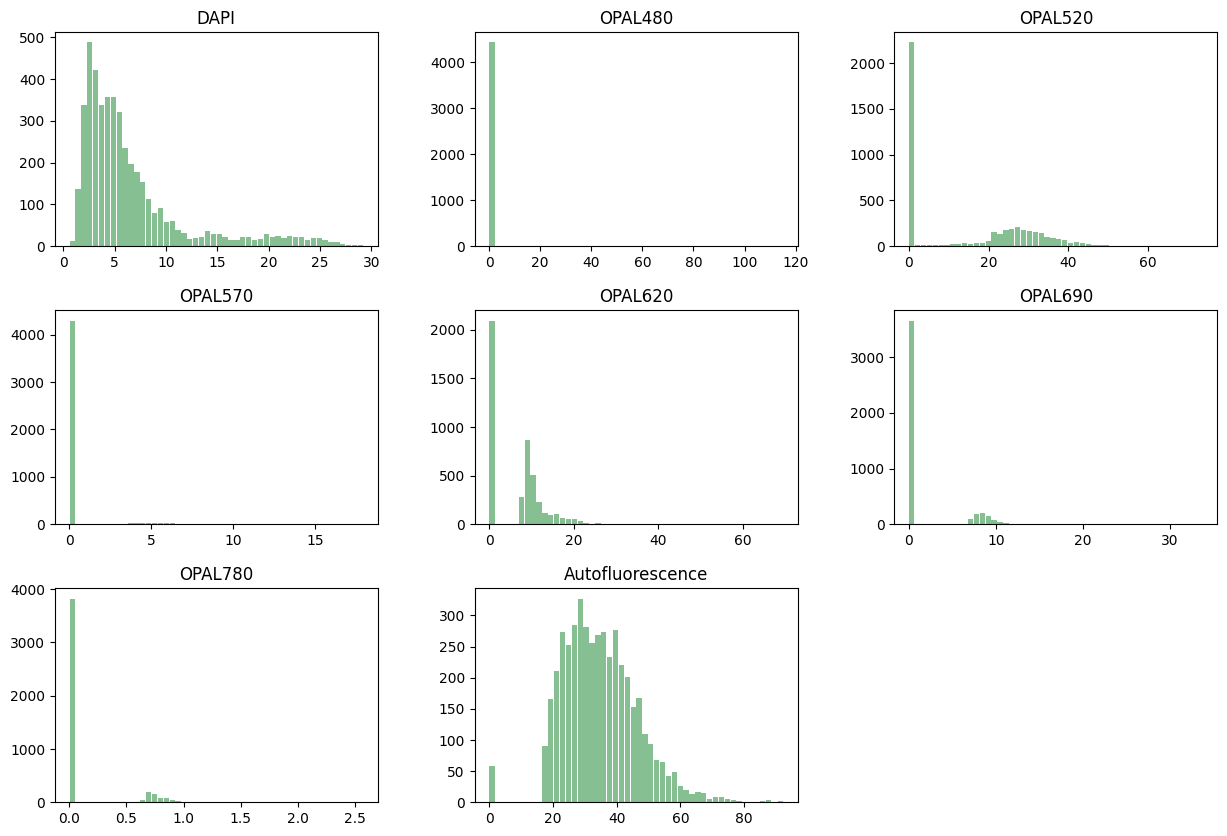

In [28]:
images = [ref_img[(x),:,:] for x in range(ref_img.shape[0])] # for each channel
cols = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']

# get enlarged-labels image as a binary mask
enlarged_binary_mask = enlarged_labels.copy()
enlarged_binary_mask[enlarged_binary_mask > 0] = 1

tables = []
i = 0
for img in images:
        
    filteredByNucleiMask = enlarged_binary_mask * img # for each channel, exclude regions that are outside of the cellular region defined by the segmentation segmentation

    if i == 0: # nuclei image, copy original labeled mask
        thresholded = enlarged_binary_mask
        
    elif i==2: # 520 channel, read mask from Ilastik segmentation

        # load mask image
        label520 = io.imread(os.path.join(inputpath, ilastik_mask))
        thresholded = (label520 == 1) * 1

    else:
        thr = threshold_otsu(filteredByNucleiMask)
        thresholded = (img >= thr) * 1

    io.imsave(outpath + '/filteredByNucleiMask_' + cols[i] + '.tif', filteredByNucleiMask)
    io.imsave(outpath + '/filteredByNucleiMask_intens_' + cols[i] + '.tif', filteredByNucleiMask*thresholded)
    io.imsave(outpath + '/binary_' + cols[i] + '.tif', util.img_as_ubyte(thresholded*255))

    nonzero_intensity_means = measure.regionprops_table(labels, filteredByNucleiMask*thresholded, properties=['label'], extra_properties=[nonzero_intensity_mean])
    tables.append(nonzero_intensity_means)
    i=i+1

mean_intens = export_table_to_dataframe(tables, cols)
mean_intens.to_csv(os.path.join(outpath, 'mean_intensity_threshold.csv'), sep=';')
mean_intens

nBins = 50
ax = mean_intens.hist(bins=nBins, grid=False, figsize=(15,10), color='#86bf91', zorder=2, rwidth=0.9)